## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему. 

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv`

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
import torch
from rectools.models import SASRecModel
from rectools.dataset import Dataset
from xgboost import XGBRanker, XGBClassifier, plot_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, ndcg_score
import shap

In [2]:
# скачиваем данные
# если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

# !pip3 install gdown


# import gdown
# # train
# url = "https://drive.google.com/file/d/1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-/view?usp=drive_link"
# output = 'train.csv'
# gdown.download(url, output, quiet=False)

# # test
# url = "https://drive.google.com/file/d/11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG/view?usp=drive_link"
# output = 'test.csv'
# gdown.download(url, output, quiet=False)



### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно. 

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



In [3]:
train_df = pd.read_csv('train_part.csv')
test_df = pd.read_csv('test_part.csv')
users_df = pd.read_csv('users.csv')
items_df = pd.read_csv('items.csv')

In [4]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,2021-03-13,4485,98.0,1
1,952323,15997,2021-03-13,7507,100.0,1
2,889459,11460,2021-03-13,60,0.0,0
3,854016,11237,2021-03-13,5381,98.0,1
4,307257,9132,2021-03-13,5814,100.0,1


In [5]:
# Добавляем колонку с днем, в который произошла интеракция, за 0 берем самый ранний день
train_df['timestamp'] = (
        pd.to_datetime(train_df['last_watch_dt']) - pd.to_datetime(train_df['last_watch_dt']).min()).dt.days
test_df['timestamp'] = (
        pd.to_datetime(test_df['last_watch_dt']) - pd.to_datetime(train_df['last_watch_dt']).min()).dt.days

# train_df['timestamp'] = pd.to_datetime(train_df['last_watch_dt']).apply(lambda x: x.timestamp())
# test_df['timestamp'] = pd.to_datetime(train_df['last_watch_dt']).apply(lambda x: x.timestamp())

In [6]:
# Делаем, чтобы все айдишники были от 0 до количества уникальных юзеров
unique_users = np.unique(np.concatenate((train_df['user_id'], test_df['user_id'], users_df['user_id'])))
unique_items = np.unique(np.concatenate((train_df['item_id'], test_df['item_id'], items_df['item_id'])))

user2id = {user: idx for idx, user in enumerate(unique_users)}
item2id = {item: idx for idx, item in enumerate(unique_items)}

train_df['user_id'] = train_df['user_id'].apply(lambda x: user2id[x])
test_df['user_id'] = test_df['user_id'].apply(lambda x: user2id[x])

train_df['item_id'] = train_df['item_id'].apply(lambda x: item2id[x])
test_df['item_id'] = test_df['item_id'].apply(lambda x: item2id[x])

users_df['user_id'] = users_df['user_id'].apply(lambda x: user2id[x])
items_df['item_id'] = items_df['item_id'].apply(lambda x: item2id[x])

In [7]:
# Разбиваем датасет по времени. В train_stage_1 берем все интеракции до max_day - delta, в valid_stage_1 остальные
max_day = train_df.timestamp.max()
delta = 7

train_stage_1 = train_df.loc[(train_df.timestamp < max_day - delta)]
valid_stage_1 = train_df.loc[(train_df.timestamp >= max_day - delta)]
assert train_stage_1.timestamp.max() < valid_stage_1.timestamp.min()

unique_users_train_stage_1 = train_stage_1['user_id'].unique()
unique_users_valid_stage_1 = valid_stage_1['user_id'].unique()

print(len(unique_users_train_stage_1), len(unique_users_valid_stage_1))
print(
    f'Количество юзеров и в train_stage_1 в valid_stage_1: {np.intersect1d(unique_users_train_stage_1, unique_users_valid_stage_1).shape[0]}')

819278 170259
Количество юзеров и в train_stage_1 в valid_stage_1: 109116


In [8]:
# Если есть запись в датасете, то считаем, что юзер посмотрел айтем, не смотрим на колонку target

def create_sparse_interactions_matrix(df: pd.DataFrame, index='user_id', columns='item_id'):
    data = np.ones(len(df))
    row_indices = df[index].values
    col_indices = df[columns].values
    n_users = np.max(row_indices) + 1
    n_items = np.max(col_indices) + 1

    return csr_matrix((data, (row_indices, col_indices)), shape=(n_users, n_items))

# valid_stage_1_interactions = create_sparse_interactions_matrix(valid_stage_1)
# train_stage_1_interactions = create_sparse_interactions_matrix(train_stage_1)

In [9]:
# Считаем, что пользователь посмотрел айтем, только если в соответствующей колонке target стоит 1

def create_sparse_interactions_matrix_with_target(df: pd.DataFrame, index='user_id', columns='item_id',
                                                  target='target'):
    df_filtered = df[df[target] == 1]

    data = np.ones(len(df_filtered))
    row_indices = df_filtered[index].values
    col_indices = df_filtered[columns].values
    n_users = np.max(row_indices) + 1
    n_items = np.max(col_indices) + 1

    return csr_matrix((data, (row_indices, col_indices)), shape=(n_users, n_items))


valid_stage_1_interactions = create_sparse_interactions_matrix_with_target(valid_stage_1)
train_stage_1_interactions = create_sparse_interactions_matrix_with_target(train_stage_1)

Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**

#### Эвристическая модель
Модель рекомендует самые популярные айтемы. Если в метод predicted передать интеракции пользователя, то модель не будет рекомендовать айтемы, с которыми пользователь уже взаимодействовал.

In [10]:
class TopPopular:
    def __init__(self, default_score=0.0):
        self.trained = False
        self.default_score = default_score

    def fit(self, interactions: csr_matrix):
        self.item_popularity = np.array(np.sum(interactions, axis=0)).squeeze()
        self.ranking = np.argsort(-self.item_popularity)
        self.trained = True

    def recommend(self, user_interactions: csr_matrix = None, top_k: int = 10):
        if not self.trained:
            raise ValueError

        if user_interactions is None:
            return self.ranking[:top_k].tolist()
        else:
            interacted = np.array(user_interactions.todense()).squeeze() > 0
            predicted = []
            for item in self.ranking:
                if not interacted[item]:
                    predicted.append(item)
                if len(predicted) >= top_k:
                    break
            return predicted

    def score(self, item: int) -> float:
        if not self.trained:
            return self.default_score
        if item < 0 or item >= len(self.item_popularity):
            return self.default_score

        return self.item_popularity[item]


In [11]:
my_heuristic_model = TopPopular()
my_heuristic_model.fit(train_stage_1_interactions)

In [12]:
def ndcg_metric(gt_items, predicted):
    at = len(predicted)
    relevance = np.array([1 if item in gt_items else 0 for item in predicted])
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    ideal_relevance = np.sort(relevance)[::-1][:at]
    ideal_dcg = dcg(ideal_relevance)

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores):
    return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
                  dtype=np.float64)


def recall_metric(gt_items, predicted):
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_heuristic_model(df):
    df = df[df['target'] == 1]
    user_gt = df.groupby('user_id')['item_id'].apply(list)
    recommended = my_heuristic_model.recommend()

    metric_values = []
    for user, gt_items in tqdm(user_gt.items(), total=len(user_gt), desc="Evaluating"):
        ndcg = ndcg_metric(gt_items, recommended)
        recall = recall_metric(gt_items, recommended)
        metric_values.append((ndcg, recall))

    return {
        'ndcg': np.mean([x[0] for x in metric_values]),
        'recall': np.mean([x[1] for x in metric_values])
    }


evaluate_heuristic_model(valid_stage_1)

Evaluating: 100%|██████████| 81266/81266 [00:00<00:00, 109384.20it/s]


{'ndcg': 0.2036671666682141, 'recall': 0.2718537194208964}

#### Модель матричной факторизации

In [13]:
my_matrix_factorization = AlternatingLeastSquares(iterations=15)
my_matrix_factorization.fit(train_stage_1_interactions)

/Users/ivanpleskov/.pyenv/versions/recsys/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [14]:
def evaluate_matrix_factorization_model(df, train_matrix, top_k=10):
    df = df[df['target'] == 1]
    user_gt = df.groupby('user_id')['item_id'].apply(list)

    metric_values = []
    for user, gt_items in tqdm(user_gt.items(), total=len(user_gt), desc="Evaluating"):
        recs = my_matrix_factorization.recommend(user, train_matrix[user], N=top_k)
        if recs and isinstance(recs[0], tuple):
            recommended = [item for item, _ in recs]
        else:
            recommended = recs

        ndcg = ndcg_metric(gt_items, recommended[0])
        recall = recall_metric(gt_items, recommended[0])
        metric_values.append((ndcg, recall))

    return {
        'ndcg': np.mean([x[0] for x in metric_values]),
        'recall': np.mean([x[1] for x in metric_values])
    }


evaluate_matrix_factorization_model(valid_stage_1, train_stage_1_interactions, top_k=10)

Evaluating: 100%|██████████| 81266/81266 [00:13<00:00, 6099.43it/s]


{'ndcg': 0.02969148766232318, 'recall': 0.029002818093920683}

#### Нейросетевая модель

In [15]:
def create_dataser_for_SasRec(df: pd.DataFrame, user_id='user_id', item_id='item_id', timestamp='last_watch_dt',
                              target='target'):
    interactions_df = df.copy()
    interactions_df['last_watch_dt'] = pd.to_datetime(interactions_df['last_watch_dt'])
    interactions_df = interactions_df[[user_id, item_id, timestamp, target]]
    interactions_df.rename(columns={timestamp: 'datetime', target: 'weight'}, inplace=True)
    return interactions_df


train_stage_1_interactions_sasrec = create_dataser_for_SasRec(train_stage_1)
dataset = Dataset.construct(train_stage_1_interactions_sasrec)

In [16]:
sasrec = SASRecModel(
    session_max_len=20,
    loss="softmax",
    n_factors=64,
    n_blocks=1,
    n_heads=4,
    dropout_rate=0.2,
    lr=0.001,
    batch_size=128,
    epochs=5,
    verbose=1,
)
sasrec.fit(dataset)



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ivanpleskov/.pyenv/versions/recsys/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/ivanpleskov/.pyenv/versions/recsys/lib/python3.12/site-packages/rectools/dataset/identifiers.py:60: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unq_values = pd.unique(values)
/Users/ivanpleskov/.pyenv/versions/recsys

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [17]:
def evaluate_sasrec_model(df, top_k=10):
    df = df[df['target'] == 1]
    user_gt = df.groupby('user_id')['item_id'].apply(list)

    sasrec_recs = sasrec.recommend(
        users=df['user_id'].unique(),
        dataset=dataset,
        k=top_k,
        filter_viewed=True,
        on_unsupported_targets="warn"
    )
    recommended = sasrec_recs.groupby('user_id')['item_id'].apply(list)

    metric_values = []
    for user, gt_items in tqdm(user_gt.items(), total=len(user_gt), desc="Evaluating"):
        recs = recommended.get(user, [])
        ndcg = ndcg_metric(gt_items, recs)
        recall = recall_metric(gt_items, recs)
        metric_values.append((ndcg, recall))

    return {
        'ndcg': np.mean([x[0] for x in metric_values]),
        'recall': np.mean([x[1] for x in metric_values])
    }


evaluate_sasrec_model(valid_stage_1, top_k=10)

/Users/ivanpleskov/.pyenv/versions/recsys/lib/python3.12/site-packages/rectools/models/nn/transformers/data_preparator.py:332: UserWarning: 23612 target users were considered cold because of missing known items
  warnings.warn(explanation)
/Users/ivanpleskov/.pyenv/versions/recsys/lib/python3.12/site-packages/rectools/models/base.py:695: UserWarning: 
                Model `<class 'rectools.models.nn.transformers.sasrec.SASRecModel'>` doesn't support recommendations for cold users,
                but some of given users are cold: they are not in the `dataset.user_id_map`
            
  warnings.warn(explanation)
Evaluating: 100%|██████████| 81266/81266 [00:00<00:00, 101787.69it/s]


{'ndcg': 0.1548145926590218, 'recall': 0.18126931794676004}


### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)). 

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

Посчитаем новые признаки на первый день теста и первый день трейна, то есть как в пункте 1.

In [18]:
def compute_item_age_genre_popularity(interactions,
                                      item_id_column='item_id',
                                      age_column='age',
                                      genres_column='genres'):
    df = interactions.copy()
    df['genre_list'] = df[genres_column].fillna('').apply(
        lambda x: [g.strip() for g in x.split(',') if g.strip()]
    )

    df_exploded = df.explode('genre_list')
    df_exploded = df_exploded[df_exploded['genre_list'] != '']

    age_genre_counts = df_exploded.groupby([age_column, 'genre_list']).size().reset_index(name='genre_count')

    age_total_counts = df_exploded.groupby(age_column).size().reset_index(name='total_count')

    age_genre_pop = age_genre_counts.merge(age_total_counts, on=age_column)
    age_genre_pop['genre_popularity'] = age_genre_pop['genre_count'] / age_genre_pop['total_count']

    genre_pop_dict = {
        (row[age_column], row['genre_list']): row['genre_popularity']
        for _, row in age_genre_pop.iterrows()
    }

    def calc_genre_pop(row):
        user_age = row[age_column]
        genres_str = row[genres_column]
        if pd.isna(genres_str):
            return None
        genres = [g.strip() for g in genres_str.split(',') if g.strip()]
        if not genres:
            return None
        pops = [genre_pop_dict.get((user_age, genre), 0) for genre in genres]
        return sum(pops) / len(pops)

    df['genre_popularity'] = df.apply(calc_genre_pop, axis=1)

    item_age_features = df.groupby([item_id_column, age_column])['genre_popularity'] \
        .agg(['mean', 'median']).reset_index()
    item_age_features = item_age_features.rename(columns={
        'mean': 'avg_genre_popularity_by_age',
        'median': 'median_genre_popularity_by_age'
    })

    df.drop(columns=['genre_list'], inplace=True)

    return item_age_features


def compute_item_kids_genre_popularity(interactions, item_id_column='item_id', kids_column='kids_flg',
                                       genres_column='genres'):
    df = interactions.copy()

    df['genre_list'] = df[genres_column].fillna('').apply(
        lambda x: [g.strip() for g in x.split(',') if g.strip()]
    )

    df_exploded = df.explode('genre_list')
    df_exploded = df_exploded[df_exploded['genre_list'] != '']

    kids_genre_counts = df_exploded.groupby([kids_column, 'genre_list']).size().reset_index(name='genre_count')

    kids_total_counts = df_exploded.groupby(kids_column).size().reset_index(name='total_count')

    kids_genre_pop = kids_genre_counts.merge(kids_total_counts, on=kids_column)
    kids_genre_pop['genre_popularity'] = kids_genre_pop['genre_count'] / kids_genre_pop['total_count']

    genre_kids_pop_dict = {
        (row[kids_column], row['genre_list']): row['genre_popularity']
        for _, row in kids_genre_pop.iterrows()
    }

    def calc_genre_pop(row):
        user_kids = row[kids_column]
        genres_str = row[genres_column]
        if pd.isna(genres_str):
            return None
        genres = [g.strip() for g in genres_str.split(',') if g.strip()]
        if not genres:
            return None
        pops = [genre_kids_pop_dict.get((user_kids, genre), 0) for genre in genres]
        return sum(pops) / len(pops)

    df['genre_popularity'] = df.apply(calc_genre_pop, axis=1)

    item_kids_features = df.groupby([item_id_column, kids_column])['genre_popularity'] \
        .agg(['mean', 'median']).reset_index()
    item_kids_features = item_kids_features.rename(columns={
        'mean': 'avg_genre_popularity_by_kids',
        'median': 'median_genre_popularity_by_kids'
    })

    df.drop(columns=['genre_list'], inplace=True)

    return item_kids_features


def compute_item_director_popularity_by_sex(interactions, item_id_column='item_id', sex_column='sex',
                                            directors_column='directors', watched_pct_column='watched_pct'):
    df = interactions.copy()

    df['director_list'] = df[directors_column].fillna('').apply(
        lambda x: [d.strip() for d in x.split(',') if d.strip()]
    )

    df_exploded = df.explode('director_list')
    df_exploded = df_exploded[df_exploded['director_list'] != '']

    director_stats = df_exploded.groupby([sex_column, 'director_list'])[watched_pct_column] \
        .mean().reset_index() \
        .rename(columns={watched_pct_column: 'avg_watched_pct_director'})

    director_dict = {
        (row[sex_column], row['director_list']): row['avg_watched_pct_director']
        for _, row in director_stats.iterrows()
    }

    def calc_director_pop_by_sex(row):
        user_sex = row[sex_column]
        directors_str = row[directors_column]
        if pd.isna(directors_str):
            return None
        directors = [d.strip() for d in directors_str.split(',') if d.strip()]
        if not directors:
            return None
        values = [director_dict.get((user_sex, d), 0) for d in directors]
        return sum(values) / len(values)

    df['director_popularity_by_sex'] = df.apply(calc_director_pop_by_sex, axis=1)

    item_sex_features = df.groupby([item_id_column, sex_column])['director_popularity_by_sex'] \
        .agg(['mean', 'median']).reset_index()
    item_sex_features = item_sex_features.rename(columns={
        'mean': 'avg_director_popularity_by_sex',
        'median': 'median_director_popularity_by_sex'
    })

    df.drop(columns=['director_list'], inplace=True)

    return item_sex_features


def compute_item_director_popularity_by_age(interactions, item_id_column='item_id', age_column='age',
                                            directors_column='directors', watched_pct_column='watched_pct'):
    df = interactions.copy()

    df['director_list'] = df[directors_column].fillna('').apply(
        lambda x: [d.strip() for d in x.split(',') if d.strip()]
    )

    df_exploded = df.explode('director_list')
    df_exploded = df_exploded[df_exploded['director_list'] != '']

    director_age_stats = df_exploded.groupby([age_column, 'director_list'])[watched_pct_column] \
        .mean().reset_index() \
        .rename(columns={watched_pct_column: 'avg_watched_pct_director_age'})

    director_age_dict = {
        (row[age_column], row['director_list']): row['avg_watched_pct_director_age']
        for _, row in director_age_stats.iterrows()
    }

    def calc_director_pop_by_age(row):
        user_age = row[age_column]
        directors_str = row[directors_column]
        if pd.isna(directors_str):
            return None
        directors = [d.strip() for d in directors_str.split(',') if d.strip()]
        if not directors:
            return None
        values = [director_age_dict.get((user_age, d), 0) for d in directors]
        return sum(values) / len(values)

    df['director_popularity_by_age'] = df.apply(calc_director_pop_by_age, axis=1)

    item_age_features = df.groupby([item_id_column, age_column])['director_popularity_by_age'] \
        .agg(['mean', 'median']).reset_index()
    item_age_features = item_age_features.rename(columns={
        'mean': 'avg_director_popularity_by_age',
        'median': 'median_director_popularity_by_age'
    })

    df.drop(columns=['director_list'], inplace=True)

    return item_age_features


def make_user_features(interactions: pd.DataFrame, user_features: pd.DataFrame, item_features: pd.DataFrame,
                       cutoff_day: int) -> pd.DataFrame:
    interactions = interactions[interactions['timestamp'] < cutoff_day]
    interactions = interactions.merge(user_features, how='left', on='user_id')
    interactions = interactions.merge(item_features[['item_id', 'release_year']], how='left', on='item_id')

    age_agg = interactions.groupby('age')['watched_pct'].mean().reset_index().rename(
        columns={'watched_pct': 'avg_watched_pct_age_group'})
    user_agg = interactions.groupby('user_id').agg(
        avg_watched_pct_user=('watched_pct', 'mean'),
        count_films=('item_id', 'count'),
        avg_release_year=('release_year', 'mean')
    ).reset_index()

    user_features = user_features.merge(age_agg, how='left', on='age')
    user_features = user_features.merge(user_agg, how='left', on='user_id')
    return user_features


def make_item_features(interactions: pd.DataFrame, item_features: pd.DataFrame, cutoff_day: int) -> pd.DataFrame:
    interactions = interactions[interactions['timestamp'] < cutoff_day]
    interactions = interactions.merge(item_features, how='left', on='item_id')

    avg_item_watched_pct = interactions.groupby('item_id')['watched_pct'].mean().reset_index().rename(
        columns={'watched_pct': 'avg_watched_pct'})
    median_item_watched_pct = interactions.groupby('item_id')['watched_pct'].median().reset_index().rename(
        columns={'watched_pct': 'median_watched_pct'})

    item_features = item_features.merge(avg_item_watched_pct, how='left', on='item_id')
    item_features = item_features.merge(median_item_watched_pct, how='left', on='item_id')

    return item_features


def make_user_item_features(hist_interactions: pd.DataFrame, interactions: pd.DataFrame, user_features: pd.DataFrame,
                            item_features: pd.DataFrame, cutoff_day: int):
    hist_interactions = hist_interactions[hist_interactions['timestamp'] < cutoff_day]
    hist_interactions = hist_interactions.merge(user_features, how='left', on='user_id')
    hist_interactions = hist_interactions.merge(item_features, how='left', on='item_id')

    gener_pop_by_age = compute_item_age_genre_popularity(hist_interactions)
    gener_pop_by_kids = compute_item_kids_genre_popularity(hist_interactions)
    director_pop_by_sex = compute_item_director_popularity_by_sex(hist_interactions)
    director_pop_by_age = compute_item_director_popularity_by_age(hist_interactions)

    interactions = interactions.merge(gener_pop_by_age, how='left', on=['item_id', 'age'])
    interactions = interactions.merge(gener_pop_by_kids, how='left', on=['item_id', 'kids_flg'])
    interactions = interactions.merge(director_pop_by_sex, how='left', on=['item_id', 'sex'])
    interactions = interactions.merge(director_pop_by_age, how='left', on=['item_id', 'age'])

    return interactions


In [19]:
cutoff_day_train = valid_stage_1['timestamp'].max() + 1
users_with_features = make_user_features(train_df, users_df, items_df, cutoff_day_train)
items_with_features = make_item_features(train_df, items_df, cutoff_day_train)
train_df_with_features = valid_stage_1.copy()
train_df_with_features = train_df_with_features.merge(users_with_features, how='left', on='user_id')
train_df_with_features = train_df_with_features.merge(items_with_features, how='left', on='item_id')

train_df_with_features = make_user_item_features(train_df, train_df_with_features, users_df, items_df, cutoff_day_train)

cutoff_day_test = train_df['timestamp'].max() + 1
users_with_features_test = make_user_features(train_df, users_df, items_df, cutoff_day_test)
items_with_features_test = make_item_features(train_df, items_df, cutoff_day_test)
test_df_with_features = test_df.copy()
test_df_with_features = test_df_with_features.merge(users_with_features_test, how='left', on='user_id')
test_df_with_features = test_df_with_features.merge(items_with_features_test, how='left', on='item_id')

test_df_with_features = make_user_item_features(train_df, test_df_with_features, users_df, items_df, cutoff_day_test)



In [20]:
sasrec_recs = sasrec.recommend(
    users=train_df_with_features['user_id'].values,
    dataset=dataset,
    k=100,
    filter_viewed=True,
    on_unsupported_targets="warn"
)


def score_user_item(model, user_index, item_index, default_score=0.0):
    if user_index >= model.user_factors.shape[0] or item_index >= model.item_factors.shape[0]:
        return default_score
    return np.dot(model.user_factors[user_index], model.item_factors[item_index])


train_df_with_features['heuristic_model_score'] = train_df_with_features['item_id'].apply(
    lambda x: my_heuristic_model.score(x))

train_df_with_features['matrix_factorization_model_score'] = train_df_with_features[['user_id', 'item_id']].apply(
    lambda x: score_user_item(my_matrix_factorization, x['user_id'], x['item_id']), axis=1)

train_df_with_features = train_df_with_features.merge(sasrec_recs[['user_id', 'item_id', 'score']], how='left',
                                                      on=['user_id', 'item_id']).rename(
    columns={'score': 'sasrec_model_score'})

test_df_with_features['heuristic_model_score'] = test_df_with_features['item_id'].apply(
    lambda x: my_heuristic_model.score(x))

test_df_with_features['matrix_factorization_model_score'] = test_df_with_features[['user_id', 'item_id']].apply(
    lambda x: score_user_item(my_matrix_factorization, x['user_id'], x['item_id']), axis=1)

test_df_with_features = test_df_with_features.merge(sasrec_recs[['user_id', 'item_id', 'score']], how='left',
                                                    on=['user_id', 'item_id']).rename(
    columns={'score': 'sasrec_model_score'})

/Users/ivanpleskov/.pyenv/versions/recsys/lib/python3.12/site-packages/rectools/models/nn/transformers/data_preparator.py:332: UserWarning: 335072 target users were considered cold because of missing known items
  warnings.warn(explanation)
/Users/ivanpleskov/.pyenv/versions/recsys/lib/python3.12/site-packages/rectools/models/base.py:695: UserWarning: 
                Model `<class 'rectools.models.nn.transformers.sasrec.SASRecModel'>` doesn't support recommendations for cold users,
                but some of given users are cold: they are not in the `dataset.user_id_map`
            
  warnings.warn(explanation)


In [92]:
X_train = train_df_with_features.drop(
    columns=['watched_pct', 'last_watch_dt', 'target', 'timestamp', 'description', 'median_watched_pct',
             'median_genre_popularity_by_age', 'median_genre_popularity_by_kids', 'median_director_popularity_by_sex',
             'median_director_popularity_by_age', 'title', 'title_orig', 'genres', 'countries', 'studios', 'directors',
             'actors', 'keywords', 'total_dur'])
y_train = train_df_with_features['target']

X_test = test_df_with_features.drop(
    columns=['watched_pct', 'last_watch_dt', 'target', 'timestamp', 'description', 'median_watched_pct',
             'median_genre_popularity_by_age', 'median_genre_popularity_by_kids', 'median_director_popularity_by_sex',
             'median_director_popularity_by_age', 'title', 'title_orig', 'genres', 'countries', 'studios', 'directors',
             'actors', 'keywords', 'total_dur'])
y_test = test_df_with_features['target']

categories_features = ['age', 'income', 'sex', 'kids_flg', 'content_type', 'for_kids']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_train = encoder.fit_transform(X_train[categories_features])
encoded_test = encoder.transform(X_test[categories_features])
encoded_feature_names = encoder.get_feature_names_out(categories_features)
encoded_train_df = pd.DataFrame(encoded_train, columns=encoded_feature_names, index=X_train.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoded_feature_names, index=X_test.index)

X_train = pd.concat([X_train.drop(columns=categories_features), encoded_train_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categories_features), encoded_test_df], axis=1)



### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [93]:
classifier = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print(report)

Accuracy: 0.6622058482959406
              precision    recall  f1-score   support

           0       0.71      0.72      0.72    504857
           1       0.58      0.57      0.58    341475

    accuracy                           0.66    846332
   macro avg       0.65      0.65      0.65    846332
weighted avg       0.66      0.66      0.66    846332



<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

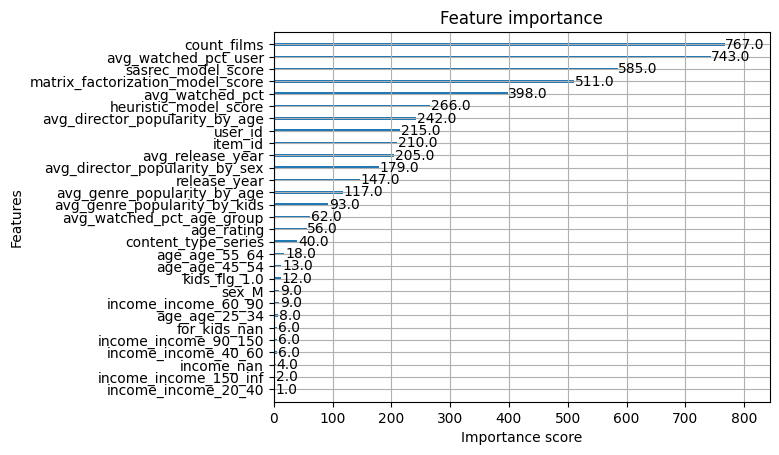

In [94]:
plot_importance(classifier)


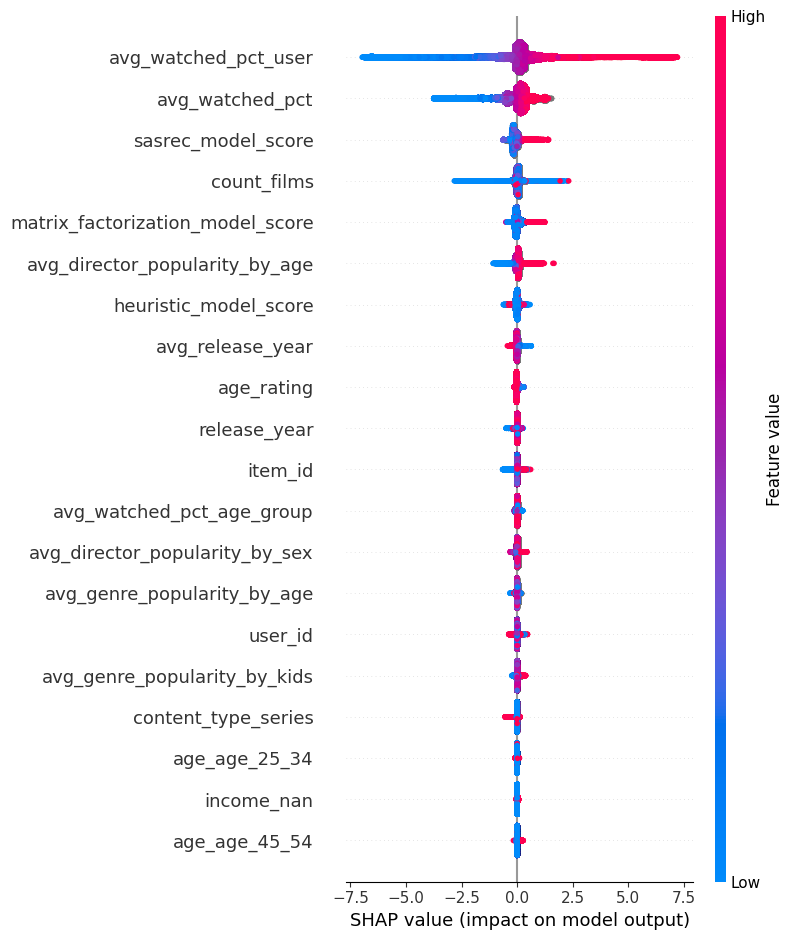

In [95]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)



### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

Обучение моделей 1 уровня на всех данных

In [30]:
full_dataset = pd.concat([train_df, test_df], ignore_index=True)


In [31]:
heuristic_model = TopPopular()
heuristic_model.fit(train_stage_1_interactions)

In [32]:
full_dataset_interactions = create_sparse_interactions_matrix_with_target(full_dataset)
matrix_factorization = AlternatingLeastSquares(iterations=15)
matrix_factorization.fit(full_dataset_interactions)

  0%|          | 0/15 [00:00<?, ?it/s]

In [33]:
full_dataset_sasrec = create_dataser_for_SasRec(full_dataset)
dataset_sasrec_full = Dataset.construct(full_dataset_sasrec)

sasrec_full = SASRecModel(
    session_max_len=20,
    loss="softmax",
    n_factors=64,
    n_blocks=1,
    n_heads=4,
    dropout_rate=0.2,
    lr=0.001,
    batch_size=128,
    epochs=5,
    verbose=1,
)
sasrec_full.fit(dataset_sasrec_full)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ivanpleskov/.pyenv/versions/recsys/lib/python3.12/site-packages/rectools/dataset/identifiers.py:60: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unq_values = pd.unique(values)
/Users/ivanpleskov/.pyenv/versions/recsys/lib/python3.12/site-packages/rectools/models/nn/item_net.py:129: UserWarning: Ignoring `CatFeaturesItemNet` block because dataset doesn't contain item features.
  warnings.warn(explanation)
/Users/ivanpleskov/.pyenv/versions/recsys/lib/python3.12/site-packages/pydantic/main.py:453: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=('rectools.models.nn.item...net.CatFeaturesItemNet'), input_type=tuple])
  return self.__pydantic_serializer__.to_pytho

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Генерация рекомендаций для каждого пользователя

In [34]:
def generate_candidates_toppopular(model, df, top_k=10):
    users = df['user_id'].unique()
    candidates = model.recommend(top_k=top_k)
    return {user: candidates for user in users}


def generate_candidates_als(model, df, train_matrix, top_k=10):
    users = df['user_id'].unique()
    candidates = {}
    als_score = {}
    for user in tqdm(users, desc="Generating ALS candidates", total=len(users)):
        recs = model.recommend(user, train_matrix[user], N=top_k)
        if recs and isinstance(recs[0], tuple):
            recs = [item for item, score in recs]
        candidates[user] = recs[0]
        als_score[user] = recs[1]
    return candidates, als_score


def generate_candidates_sasrec(model, df, dataset, top_k=10):
    users = df['user_id'].unique()
    sasrec_recs = model.recommend(
        users=users,
        dataset=dataset,
        k=top_k,
        filter_viewed=True,
        on_unsupported_targets="warn"
    )
    candidates = sasrec_recs.groupby('user_id')['item_id'].apply(list).to_dict()
    return candidates, sasrec_recs


k = 10
toppopular_candidates = generate_candidates_toppopular(heuristic_model, full_dataset, top_k=k)
als_candidates, als_score = generate_candidates_als(matrix_factorization, full_dataset, full_dataset_interactions,
                                                    top_k=k)
sasrec_candidates, sasrec_rec = generate_candidates_sasrec(sasrec_full, full_dataset, dataset_sasrec_full, top_k=k)


Generating ALS candidates: 100%|██████████| 962151/962151 [02:10<00:00, 7357.46it/s]
/Users/ivanpleskov/.pyenv/versions/recsys/lib/python3.12/site-packages/rectools/models/nn/transformers/data_preparator.py:332: UserWarning: 124 target users were considered cold because of missing known items
  warnings.warn(explanation)
/Users/ivanpleskov/.pyenv/versions/recsys/lib/python3.12/site-packages/rectools/models/base.py:695: UserWarning: 
                Model `<class 'rectools.models.nn.transformers.sasrec.SASRecModel'>` doesn't support recommendations for cold users,
                but some of given users are cold: they are not in the `dataset.user_id_map`
            
  warnings.warn(explanation)


Склеиваем всех кандидатов

In [70]:
def merge_candidates(*candidate_dicts):
    merged = {}
    all_users = set()
    for cand in candidate_dicts:
        all_users.update(cand.keys())

    for user in all_users:
        merged_set = set()
        for cand in candidate_dicts:
            if user in cand:
                merged_set.update(cand[user])
        merged[user] = list(merged_set)

    return merged


merged_candidates = merge_candidates(toppopular_candidates, als_candidates, sasrec_candidates)
df_candidates = pd.DataFrame(list(merged_candidates.items()), columns=['user_id', 'candidates'])
df_interactions = df_candidates.explode('candidates').rename(columns={'candidates': 'item_id'})


Считаем и добавляем фичи

In [71]:
df_interactions['timestamp'] = test_df['timestamp'].max() + 1

cutoff_day_train = full_dataset['timestamp'].max() + 2
users_with_features = make_user_features(full_dataset, users_df, items_df, cutoff_day_train)
items_with_features = make_item_features(full_dataset, items_df, cutoff_day_train)
df_interactions = df_interactions.merge(users_with_features, how='left', on='user_id')
df_interactions = df_interactions.merge(items_with_features, how='left', on='item_id')

df_interactions = make_user_item_features(full_dataset, df_interactions, users_df, items_df, cutoff_day_train)


In [72]:
def score_user_item(model, user_index, item_index, default_score=0.0):
    if user_index >= model.user_factors.shape[0] or item_index >= model.item_factors.shape[0]:
        return default_score
    return np.dot(model.user_factors[user_index], model.item_factors[item_index])


df_interactions['heuristic_model_score'] = df_interactions['item_id'].apply(
    lambda x: heuristic_model.score(x))

df_interactions['matrix_factorization_model_score'] = df_interactions[['user_id', 'item_id']].apply(
    lambda x: score_user_item(matrix_factorization, x['user_id'], x['item_id']), axis=1)

df_interactions = df_interactions.merge(sasrec_rec[['user_id', 'item_id', 'score']], how='left',
                                        on=['user_id', 'item_id']).rename(
    columns={'score': 'sasrec_model_score'})



Скорим всех кандидатов бустингом

In [78]:
df_interactions.drop(
    columns=['timestamp', 'description', 'median_watched_pct',
             'median_genre_popularity_by_age', 'median_genre_popularity_by_kids', 'median_director_popularity_by_sex',
             'median_director_popularity_by_age', 'title', 'title_orig', 'genres', 'countries', 'studios', 'directors',
             'actors', 'keywords'], inplace=True)

encoded_array = encoder.fit_transform(df_interactions[categories_features])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categories_features), index=df_interactions.index)
df_interactions_encoded = pd.concat([df_interactions.drop(columns=categories_features), encoded_df], axis=1)
df_interactions_encoded['item_id'] = df_interactions_encoded['item_id'].astype(int)

In [ ]:
df_interactions['xgb_score'] = classifier.predict_proba(df_interactions_encoded)[:, 1]
df_scored = df_interactions.sort_values(['user_id', 'xgb_score'], ascending=[True, False])
user_rankings = df_scored.groupby('user_id').apply(
    lambda x: x.sort_values('xgb_score', ascending=False)['item_id'].tolist()
).reset_index(name='ranked_items')


In [100]:
user_rankings

,user_id,ranked_items
0,0,"[9, 2, 1, 139, 3, 4, 0, 6, 8, 5, 7, 3599, 10072, 13387, 8333, 10839, 9393, 4000, 14769, 5251, 5940, 4337, 7527, 7560, 6576]"
1,1,"[3599, 13387, 14769, 9393, 10839, 8333, 496, 3648, 139, 10072, 4337, 6576, 4000, 1870, 1095, 12614, 14098, 2525, 9220, 2808, 6215, 11228, 15953]"
2,2,"[547, 7320, 9958, 15716, 10377, 6944, 7056, 3067, 12781, 5232, 11333, 11564, 8512, 10230, 7970, 13387, 3599, 10839, 9393, 139, 4550, 8333, 6576, 14769, 10072, 4000]"
3,3,"[3599, 9393, 139, 2844, 12781, 7056, 10072, 7309, 2222, 13387, 9055, 3067, 4000, 3560, 10839, 3648, 1373, 9016, 13372, 8333, 4337, 11228, 7560, 14769, 7527, 6576, 4709]"
4,4,"[3599, 8333, 10839, 13387, 9393, 139, 14769, 10072, 1784, 8852, 11918, 8895, 4313, 9724, 6961, 9560, 2981, 4000, 4279, 13863, 6576, 825]"
...,...,...
962146,1058078,"[2, 139, 3599, 9, 8333, 13387, 10839, 3, 1, 10072, 9393, 6, 14769, 0, 4000, 13969, 99, 4, 8, 6576, 5, 7]"
962147,1058079,"[10839, 1784, 4313, 3599, 8333, 13387, 139, 13933, 9393, 1566, 15736, 12057, 8493, 14235, 904, 6576, 3282, 13969, 1855, 14769, 10072, 4000, 24, 99]"
962148,1058080,"[10072, 14769, 13387, 3599, 2, 9, 9393, 1, 139, 4300, 3, 10839, 8333, 4337, 6576, 4000, 4, 6, 0, 8, 5, 7]"
962149,1058081,"[9, 2, 3599, 14769, 13387, 10072, 9393, 0, 6, 1, 4000, 5, 4, 3, 139, 10839, 8333, 6576, 7, 8]"
